# 整合了 任意长度字符加解密，图像加解密
# 共有三组测试：字符串加解密、图片加解密、文本文件加解密
## 有时候调用 DMA 会报错：RuntimeError: DMA channel not started
### 注意：HLS IP核中，最大输入缓冲为 345600 bytes/char 

## Import libraries

In [1]:
from pynq import Overlay
# import pynq.lib.dma
Max_buffer_size = 345600

## Download the AES bitstream

In [2]:
AES_En_De_overlay = Overlay("./bitstream/AES_En_De.bit")

In [3]:
AES_En_De = AES_En_De_overlay.AES_En_De_0
dma_ip = AES_En_De_overlay.axi_dma_0

In [4]:
sendstatus = dma_ip.sendchannel.running
recvstatus = dma_ip.recvchannel.running
print("sendstatus", sendstatus,"recvstatus",recvstatus)

sendstatus True recvstatus True


In [5]:
# AES_En_De_overlay.ip_dict

## Create an MMIO instance to Access AES_En_De

In [6]:
from pynq import MMIO
AES_En_D_address = AES_En_De_overlay.ip_dict['AES_En_De_0']['phys_addr']
addr_range = 0x40  # 64
mmio = MMIO(AES_En_D_address, addr_range)

## 调用 HLS IP 的较为底层的函数

In [7]:
from pynq import Xlnk
import numpy as np
xlnk = Xlnk()
"""
def call_AES_En_De(input_bytes, num_of_input_bytes, key_bytes_object, en_or_decryption):
较为底层的调用，实际操控 HLS IP核 的函数
    input:
        input_bytes:   长度 16 的 bytes object/bytearray 类型，  待加/解密的数据
        num_of_input_bytes:  输入input_bytes的 byte 数 
        key_bytes_object: 长度 16 的 bytes object 类型，密钥 bytes object 通过MMIO 连续写入，所以必须是bytes object
        en_or_decryption: 整型 0 加密 1 解密，          控制 HLS IP 加密还是 解密
    
    return:
        bytearray: 长度 16 的 bytearray 类型，          HLS IP 加/解密后的结果bytes object
"""
def call_AES_En_De(input_bytes, num_of_input_bytes, key_bytes_object, en_or_decryption):

    ## 通过 Xlnk()申请一块连续的区域，用于 DMA的数据传输    
    in_buffer = xlnk.cma_array(shape=(num_of_input_bytes,),dtype = np.uint8)  #uint8
    out_buffer = xlnk.cma_array(shape=(num_of_input_bytes,),dtype = np.uint8)

    ## 把待传输数据搬到 申请的地址 in_buffer
    input_bytes = np.array( bytearray(input_bytes))
    np.copyto(in_buffer,input_bytes)

    ## 写HLS IP 的key 和 必要的控制命令
    mmio.write(32, key_bytes_object )  # key  # 写可以 写一片连续地址，读无法读一片连续地址
    mmio.write(16, num_of_input_bytes )                # 明文长度，以char为单位 in_char_len[0]
    mmio.write(20, en_or_decryption ) # 0加密 1解密             in_char_len[1]
    #     mmio.write(24,0 ) # 调试信息                in_char_len[2] 

    while( not( mmio.read(0x00) & 0x4) ): # 等待 bit3 AP_READY，表示可以接收数据，也可判断AP_IDLE 为1
        pass                              # 发现无需等待，AP_READY 等不来
    ## DMA开始传输，PS-PL send .  PL-PS recv
    dma_ip.sendchannel.transfer(in_buffer)
    dma_ip.recvchannel.transfer(out_buffer)
    mmio.write(0x00, 0x01) # 往 AP_START 位写1 控制AES开始

    ## 等待DMA 传输完成
    dma_ip.sendchannel.wait()
    dma_ip.recvchannel.wait()    

    ## 取出处理完的数据
    bytes_arrray = bytearray(out_buffer)
#     print( "密文 hex：", bytes_arrray.hex() ) 
    
    return bytes_arrray

## 把 （明文）输入字符 扩展成128bits的整数倍，不足的话，补0
## 密钥 只能是 128bits，不足的话，补0，多的话，在前面需要先判断，过滤掉这种情况

In [8]:
"""
def expand_to_128b(plain_text, encoding):
使用 给定的编码方式/utf-8 编码，把 输入字符串 扩展成128bits的整数倍，不足的话，补0
    input:
        plain_text:   待扩展成 128bits/ 16 bytes 的输入字符串 
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        plain_text:   长度 16 的 bytearray 类型， 扩展成 128bits后的字符串
"""
def expand_to_128b(plain_text, encoding= "utf-8" ):
   
    if ( isinstance(plain_text, str) ):
        ## 明文扩展 
        plain_text = bytearray(plain_text.encode(encoding)) # 不用 ("ascii")，使用 utf-8 解决中文编码问题 ，   
        
    elif ( isinstance(plain_text, bytes) ):        
        plain_text = bytearray(plain_text)    # 因为 bytes object 是不可修改的，转为 bytearray 来实现 不足 补0 的操作
    
#     print("utf-8编码后，输入字符串 长度：",len(plain_text))
    len_to_add = 16 - len(plain_text)%16   
    
#     print(plain_text)
    while(len_to_add > 0 and len_to_add < 16 ):
        plain_text.append(0)                     # 加 0
        len_to_add = len_to_add - 1    
    
#     print("扩展到128bits后，输入字符串 长度：",len(plain_text))
#     print("扩展到128bits后，utf-8 解码",plain_text.decode('utf-8'))   
    
    return plain_text

# 基于Stream DMA
## 定义函数，实现任意长度密文、明文输入，相应的解密、加密输出
### 任意长度 字符串 加密/解密，不足的话补0

In [27]:
"""
def string_AES_En_De(plain_text, key_text, en_or_decryption, encoding):
任意长度 字符串 加密/解密，，不足的话补0，
使用 给定的编码方式/utf-8 编码，对字符串编码
    input:
        plain_text: 任意长度 待 加/解密，不足的话，补0
        key_text:   任意长度密钥字符串， 不足的话，补0
        en_or_decryption: 整型 0 加密 1 解密，  控制 HLS IP 加密还是 解密
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        bytearray: 加密 操作后的 bytearray  解密 操作后的 str    
        
"""
def string_AES_En_De(plain_text, key_text, en_or_decryption, encoding= "utf-8" ):

    ## 明文扩展
    #     plain_text = expand_to_128b(plain_text)    

    ## 密钥扩展
    if( len(key_text.encode( encoding ))<=16 ):      #  'utf-8'
        key_text = expand_to_128b(key_text, encoding)
    else:
        print("key length is too long, 密钥过长, "+encoding+"编码后：",len(key_text.encode( encoding ))) #  'utf-8'
        return b"this is a wrong return~~no!!!"

    result_text = bytearray()
    
    
    if ( en_or_decryption == 0):
        ## 明文扩展     
        plain_text = expand_to_128b(plain_text, encoding)       
        
        len_of_plain_text = len(plain_text)
        
        if( len_of_plain_text < Max_buffer_size):
#             pass # 直接完成
            result_text = call_AES_En_De(plain_text, len_of_plain_text, bytes(key_text), en_or_decryption)
        else:
            i = 0        
            while(i < len_of_plain_text ):
                rest_of_bytes = len_of_plain_text - i
                if(rest_of_bytes > Max_buffer_size ):
                    result_text.extend( call_AES_En_De((plain_text[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_text.extend( call_AES_En_De((plain_text[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size
        
#         result_text_str_bytes = result_text.hex() # 'utf-8'  bytearray.decode 以后，是str 加密后的东西不一定能 utf-8decode 显示成字符
        print("***加密 明文 "+encoding+" 编码后， 输出密文：",result_text)
#         print("***加密 明文 ， 输出密文 hex ：",result_text_str_bytes)
    #         print(len(result_text))




    elif ( en_or_decryption == 1):
        if ( isinstance(plain_text, str) ):
            plain_text = bytes.fromhex(plain_text)
        len_of_plain_text = len(plain_text)
        
        if( len_of_plain_text < Max_buffer_size):
#             pass # 直接完成
            result_text = call_AES_En_De(plain_text, len_of_plain_text, bytes(key_text), en_or_decryption)        
        else:
            i = 0        
            while(i < len_of_plain_text):
                rest_of_bytes = len_of_plain_text - i
                if(rest_of_bytes > Max_buffer_size ):
                    result_text.extend( call_AES_En_De((plain_text[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_text.extend( call_AES_En_De((plain_text[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size
    #         print("解密 明文：",result_text)
        
#         result_text_str_bytes = result_text
        result_text = result_text.decode( encoding ) # 'utf-8'  bytearray.decode 以后，是str
    #         print("解密 明文 utf-8：",result_text.decode('utf-8'))
        print("***解密 解密结果 "+encoding+" 解码后，输出明文：",result_text)

    return result_text

# 测试部分 

注意：HLS IP核中，最大输入缓冲为 345600 bytes/char 

## 测试1 utf-8  任意长度任意字符
可以utf-8 进行 AES 加解密的网站 https://the-x.cn/cryptography/Aes.aspx

可用来交叉验证了

In [31]:
plain_text = "this is a test string---2020年新工科联盟-Xilinx 暑期学校（Summer School）项目---  2020年8月1日02:02:15"
key_text = "Xilinx暑校"   # 做一个 判定，key 只能 128bits，不能多
encoding = "utf-8"       # 都可以用 utf-8 encoding，纯 ascii 字符的时候，可以使用 ascii编码

cipher  = string_AES_En_De(plain_text,key_text,0, encoding)
print(len(cipher))
print("密文 utf-8 hex ：",cipher.hex())

plain  = string_AES_En_De(cipher,key_text,1, encoding)
print(len(plain))
print(type(plain))
print(plain)

## 测试 同一个程序的加密/解密输出，是可以直接传进去加解密的
# cipher  = string_AES_En_De(plain, key_text,0, encoding)
# print(len(cipher))
# print("密文 hex utf-8：",cipher.hex())

# plain  = string_AES_En_De(cipher,key_text,1, encoding)
# print(len(plain))
# print(plain)

## 再对密文进行一次base64编码，似乎有点多余
# import base64
# base64.b64encode(cipher)

# help(str.encode)

***加密 明文 utf-8 编码后， 输出密文： bytearray(b'\xb6\x87\x03h-\x02\xf05\xc6p\xa1\x11\x0c\x82\xbb\x04\x82\xe1\x00\x1d\x0e\xa5MS\xfbq\x19"\'\xf4H\xba\x10\xf3Y\xa9\xb1\xba\x0c\xb2."\x16\x95\x0f\xab\xb7E\xd6\x0ekg\xc6\x1b\x93F\n\x0e\xbev\xb4`\xb4[\x8em\x91l\x8f\r\xbb\xe2nb)\x86\xb0\x9b\x8d\xc7\x04\xf2\xd7\xd3\xf9d\xd1#\xf1\xf6\x8f\'D\xd9.\xca\xd8\xce]Y\xf8\x9b\xcc\xb2]\xf4\x18-\x81\xfa\xb3\xe8k\xaaN\xc7\xdfOM\xb6lY\x9c\'\xaf\xf4\t\xc8')
128
密文 utf-8 hex ： b68703682d02f035c670a1110c82bb0482e1001d0ea54d53fb71192227f448ba10f359a9b1ba0cb22e2216950fabb745d60e6b67c61b93460a0ebe76b460b45b8e6d916c8f0dbbe26e622986b09b8dc704f2d7d3f964d123f1f68f2744d92ecad8ce5d59f89bccb25df4182d81fab3e86baa4ec7df4f4db66c599c27aff409c8
***解密 解密结果 utf-8 解码后，输出明文： this is a test string---2020年新工科联盟-Xilinx 暑期学校（Summer School）项目---  2020年8月1日02:02:15         
94
<class 'str'>
this is a test string---2020年新工科联盟-Xilinx 暑期学校（Summer School）项目---  2020年8月1日02:02:15         


### 交叉验证
1、系统的加密结果 与 在线AES加密工具加密的结果相同

2、在线AES加密工具加密的结果，可以输入系统完成正确的解密

In [37]:
cipher_hex = "b68703682d02f035c670a1110c82bb0482e1001d0ea54d53fb71192227f448ba10f359a9b1ba0cb22e2216950fabb745d60e6b67c61b93460a0ebe76b460b45b8e6d916c8f0dbbe26e622986b09b8dc704f2d7d3f964d123f1f68f2744d92ecad8ce5d59f89bccb25df4182d81fab3e86baa4ec7df4f4db66c599c27aff409c8"
plain  = string_AES_En_De((cipher_objects),key_text,1, encoding)

# cipher_objects = bytes.fromhex(cipher_hex)
# # hex = hex_str.encode('utf-8')

# # cipher_objects = cipher_hex.encode(encoding)
# print(cipher == cipher_objects)
# print(cipher)
# print(len(cipher))

# print(cipher_objects)
# print(bytearray(cipher_objects))

# print(len(cipher_objects))

# plain  = string_AES_En_De((cipher_objects),key_text,1, encoding)

***解密 解密结果 utf-8 解码后，输出明文： this is a test string---2020年新工科联盟-Xilinx 暑期学校（Summer School）项目---  2020年8月1日02:02:15         


# 文件 加解密
## 封装文件加解密函数

In [38]:
"""
def file_AES_En_De(file_name, key_text, en_or_decryption, encoding= "utf-8" ):
    input:
        file_name: "./files/" 位于./files/ 目录下的文本文件名
        key_text:   任意长度密钥字符串， 不足的话，补0
        en_or_decryption: 整型 0 加密 1 解密，  控制 HLS IP 加密还是 解密
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        str  : 写出提示
        
"""
floder_path = "./files/"
def file_AES_En_De(file_name, key_text, en_or_decryption, encoding= "utf-8" ): 
    
    result_text = bytearray()    
    
    if ( en_or_decryption == 0):
        
        ## 从file_path读数据
        f = open(floder_path + file_name ,'r',encoding = encoding)        
        plain_text= f.read()
        f.close()        
       
        result_text = string_AES_En_De( plain_text , key_text, en_or_decryption, encoding )       
    
        write_out_file_path = floder_path + "encrypted_" + file_name
        ## 写出密文 文件 
        f = open( write_out_file_path ,'wb')
        f.write(result_text)
        f.close()
        return "文件  加密 处理结束 写到文件："+ write_out_file_path

    elif ( en_or_decryption == 1):
        
        ## 读　密文 文件 　解密
        f = open(floder_path + file_name,'rb')
        #输出读取到的数据
        plain_text= f.read()
        f.close()
        
        result_text = string_AES_En_De(plain_text, key_text, en_or_decryption, encoding) #解密输出的是字符串
        
        write_out_file_path = floder_path + "decrypted_" + file_name
        ## 写出解密 文件 
        f = open( write_out_file_path ,'w')
        f.write(result_text)
        f.close()
        return "文件  解密 处理结束 写到文件："+ write_out_file_path
#     return result_text
    

## 测试2 文本 文件加解密

In [39]:
## 以 utf-8 的编码格式打开指定文件
## 测试文件需要放在 ./files/目录下
# floder_path = "./files/"
# file_name = "Welcome to Pynq.ipynb"  #test.md

file_name = "test.md" 

# def file_AES_En_De(file_name, key_text, en_or_decryption, encoding= "utf-8" )

## 从file_path读数据
f = open(floder_path + file_name ,'r',encoding =  "utf-8" )      
plain_text= f.read()
f.close()      
print("文件原文：\n"+ plain_text)

file_AES_En_De(file_name, key_text, 0, encoding= "utf-8" )
    

文件原文：
# 这是一个测试文档
## nothing is impossible
## from zero to hero 
## we made it
### 曾威康：
很开心能够顺利参加这期的暑期学校。在作为学员的同时，也作为一名助教，全程参与了一整期的学习。收获颇丰，自己也感触良多。向导师申请了两周的时间，基本在宿舍闭关，上午上课，下午晚上实验、查资料，然后到点就去饭堂吃饭的两点一线的生活，也是令人难忘。经过这一段学习经历，相信自己对FPGA的理解、对FPGA项目的开发、Vivado工具、HLS工具以及软硬件协同开发的能力都有了长足的进步。
只是，美中不足，今年的新冠疫情，无法让学员们身处同一个地方，一起学习、生活、成长、进步。
最后，感谢xilinx暑期学校的各位老师以及相关的工作人员，感谢这一段令人难忘的经历中认识到的、给我提供了巨大帮助的队友、学员们。
	
### 池杲鋆：
感谢Xilinx和一些高校为我们提供这次提高自己的平台，通过这次线上学习，意识到还有更多的知识等待我们去探索，前期学习中，老师讲解了关于HLS等知识，让我们对已有知识进行了巩固，同时扩宽了我们的知识面，对FPGA设计有了更深入了解。通过学习，对xilinx的开发套件Vivado HLS Vivado、Vitis AI一系列软件有了更深入了解，基于PYNQ-Z2开发板的项目实践，也让我切身体会到了PYNQ架构的魅力和便捷性。

### 王亚琪：
非常庆幸可以在这个特殊的暑假可以入选赛灵思的暑期学校，在线上认识了对FPGA的学习同样富有兴趣的伙伴，并在Xilinx提供的良好平台可以和大家讨论所学知识。这次之前我接触到的FPGA应用比较局限，了解过vivado的开发流程，hls的课程深入浅出讲解基于cpp的开发方向，相比之前在rtl的层次之上用纯verilog开发大大简化了代码。在结课项目当中，我扩展了自己对分组密码的加解密的知识，我希望AES加密可以作为一个入口，可以帮助我今后继续在密码方向结合fpga可重构的性质，更加深入地学习分组密码以及序列密码的优化方案。

***加密 明文 utf-8 编码后， 输出密文： bytearray(b'E\xf7\xaec2\xbe\xd9\x05v\x80\x05lH\xe6\xbb&\xf5\xcf\x0b\xb6\x9f\xee\x18$\x

'文件  加密 处理结束 写到文件：./files/encrypted_test.md'

In [40]:
## '文件  加密 处理结束 写到文件：./files/encrypted_test.md'
file_AES_En_De("encrypted_test.md", key_text, 1, encoding= "utf-8" )

***解密 解密结果 utf-8 解码后，输出明文： # 这是一个测试文档
## nothing is impossible
## from zero to hero 
## we made it
### 曾威康：
很开心能够顺利参加这期的暑期学校。在作为学员的同时，也作为一名助教，全程参与了一整期的学习。收获颇丰，自己也感触良多。向导师申请了两周的时间，基本在宿舍闭关，上午上课，下午晚上实验、查资料，然后到点就去饭堂吃饭的两点一线的生活，也是令人难忘。经过这一段学习经历，相信自己对FPGA的理解、对FPGA项目的开发、Vivado工具、HLS工具以及软硬件协同开发的能力都有了长足的进步。
只是，美中不足，今年的新冠疫情，无法让学员们身处同一个地方，一起学习、生活、成长、进步。
最后，感谢xilinx暑期学校的各位老师以及相关的工作人员，感谢这一段令人难忘的经历中认识到的、给我提供了巨大帮助的队友、学员们。
	
### 池杲鋆：
感谢Xilinx和一些高校为我们提供这次提高自己的平台，通过这次线上学习，意识到还有更多的知识等待我们去探索，前期学习中，老师讲解了关于HLS等知识，让我们对已有知识进行了巩固，同时扩宽了我们的知识面，对FPGA设计有了更深入了解。通过学习，对xilinx的开发套件Vivado HLS Vivado、Vitis AI一系列软件有了更深入了解，基于PYNQ-Z2开发板的项目实践，也让我切身体会到了PYNQ架构的魅力和便捷性。

### 王亚琪：
非常庆幸可以在这个特殊的暑假可以入选赛灵思的暑期学校，在线上认识了对FPGA的学习同样富有兴趣的伙伴，并在Xilinx提供的良好平台可以和大家讨论所学知识。这次之前我接触到的FPGA应用比较局限，了解过vivado的开发流程，hls的课程深入浅出讲解基于cpp的开发方向，相比之前在rtl的层次之上用纯verilog开发大大简化了代码。在结课项目当中，我扩展了自己对分组密码的加解密的知识，我希望AES加密可以作为一个入口，可以帮助我今后继续在密码方向结合fpga可重构的性质，更加深入地学习分组密码以及序列密码的优化方案。
             


'文件  解密 处理结束 写到文件：./files/decrypted_encrypted_test.md'

# 图片加解密

## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

In [36]:
import time
from PIL import Image
from IPython.display import display

In [37]:
"""
def image_AES_En_De(original_image, key_text, en_or_decryption, encoding = 'utf-8'):
使用 key_text 对输入的 PIL Image类original_image 进行加密解密
    input:
        original_image: PIL Image类 待 加/解密的 输入图像，不是16整数倍的话，补0
        key_text:   任意长度密钥字符串， 不足的话，补0
        en_or_decryption: 整型 0 加密 1 解密，  控制 HLS IP 加密还是 解密
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        result_image: PIL Image类 加/解密的 结果图像，
        result_image_bytes_arrray: 加/解密 操作后 结果图像 的 bytearray     
        
"""
def image_AES_En_De(original_image, key_text, en_or_decryption, encoding = 'utf-8'):
    
    ## 密钥扩展
    if( len(key_text.encode( encoding ))<=16 ):      #  'utf-8'
        key_text = expand_to_128b(key_text, encoding)
        key_text = bytes(key_text)
    else:
        print("key length is too long, 密钥过长, "+encoding+"编码后：",len(key_text.encode( encoding ))) #  'utf-8'
        return b"this is a wrong return~~no!!!"
    
    ## 图像 byte array 扩展
#     original_image = original_image.convert('L')                # RGB 太大，先灰度看看
    image_bytes_object = original_image.tobytes()  
    pic_width, pic_height = original_image.size
    
       
    image_bytes_object = expand_to_128b( image_bytes_object )    # 假如 不是 16的整数，那就凑够 16的整数
#     image_bytes_object = bytes(image_bytes_object)            # Stream 版不需要，返回的是 bytearray，所以还要转成 bytes object 才能用于调用 call_AES_En_De
    bytes_of_image     = len(image_bytes_object)  
    
    print("图像 bytes_of_image after expand_to_128b",bytes_of_image)
    
    i = 0;
    result_image_bytes_arrray = bytearray()
    
    if ( en_or_decryption == 0 ):
        ## 图像加密 

        start = time.time()        
            
        if( bytes_of_image < Max_buffer_size):
#             pass # 直接完成
            result_image_bytes_arrray = call_AES_En_De(image_bytes_object, bytes_of_image, bytes(key_text), en_or_decryption)        
        else:
            i = 0        
            while(i < bytes_of_image):
                rest_of_bytes = bytes_of_image - i
                if( rest_of_bytes > Max_buffer_size ):
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size       
            
        print(i)    
        end = time.time()
        print("加密 所用时长: " + str (end - start) )

    elif( en_or_decryption == 1 ):
        ## 图像解密 
        
        start = time.time()
        
        if( bytes_of_image < Max_buffer_size):
#             pass # 直接完成
            result_image_bytes_arrray = call_AES_En_De(image_bytes_object, bytes_of_image, bytes(key_text), en_or_decryption)        
        else:
            i = 0        
            while(i < bytes_of_image):
                rest_of_bytes = bytes_of_image - i
                if( rest_of_bytes > Max_buffer_size ):
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size  
        
        print(i)
        end = time.time()
        print("解密 所用时长: " + str (end - start) )
        
    result_image = Image.frombytes('RGB',(pic_width, pic_height ),bytes(result_image_bytes_arrray))
    return result_image, result_image_bytes_arrray

## 测试3 图像加解密  

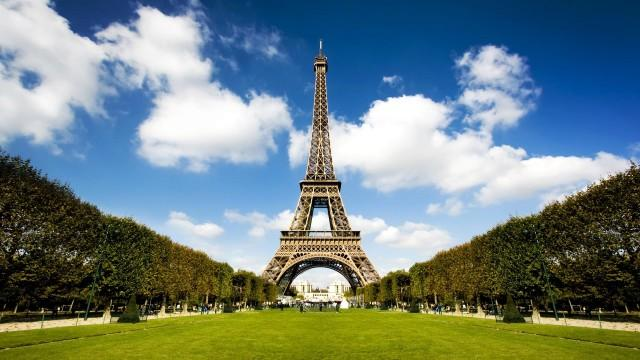

Image size: 640x360 pixels.


In [41]:
key_text = "世界你好啊"

##   /paris/paris
##  /lena/lena
##  /toys/toys
floder_path = "./images/paris/"
image_path = floder_path + "paris.jpg"

original_image = Image.open(image_path)
pic_width, pic_height = original_image.size

display(original_image)
print("Image size: {}x{} pixels.".format(pic_width, pic_height))

## 加密 图像 

图像 bytes_of_image after expand_to_128b 691200
691200
加密 所用时长: 0.11212038993835449


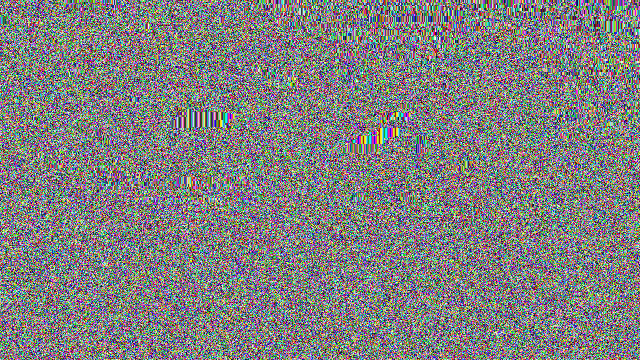

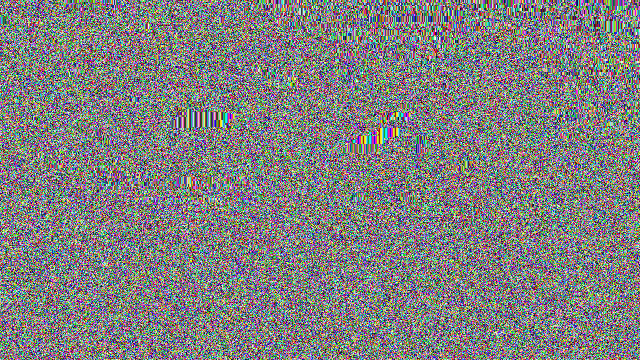

加密图


In [42]:
## 加密 图像 
encryption_image, encryption_image_bytes_arrray = image_AES_En_De(original_image, key_text, 0 )

encryption_image_bytes_arrray = bytes( encryption_image_bytes_arrray )
# encryption_image = Image.frombytes('L',(pic_width, pic_height ),encryption_image_bytes_arrray)
encryption_image2 = Image.frombytes('RGB',(pic_width, pic_height ),encryption_image_bytes_arrray)

display(encryption_image)
display(encryption_image2)
print("加密图")

## 解密 图像 

图像 bytes_of_image after expand_to_128b 691200
691200
解密 所用时长: 0.11419796943664551


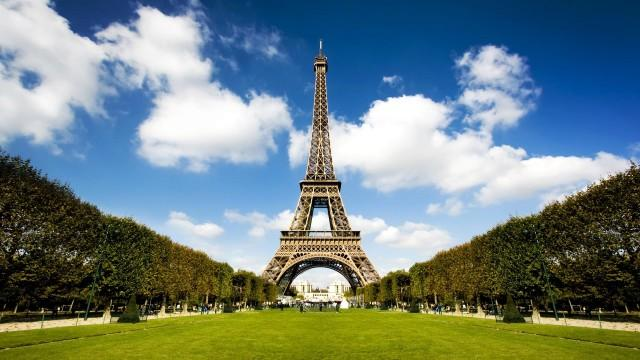

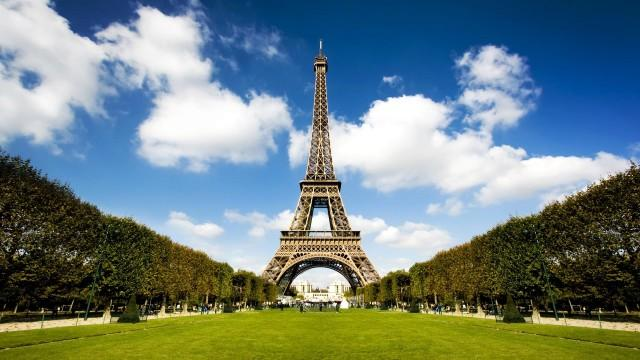

解密图


In [43]:
## 解密 图像 
decryption_image, decryption_image_bytes_arrray = image_AES_En_De(encryption_image, key_text, 1 )
decryption_image_bytes_arrray = bytes( decryption_image_bytes_arrray )

# encryption_image = Image.frombytes('L',(pic_width, pic_height ),decryption_image_bytes_arrray)
decryption_image2 = Image.frombytes('RGB',(pic_width, pic_height ),decryption_image_bytes_arrray)

display(decryption_image)
display(decryption_image2)
print("解密图")

## 保存相关图片

In [19]:
original_image.save( floder_path + "original_image.jpg")
encryption_image.save( floder_path + "encryption_image.jpg")
decryption_image.save( floder_path + "decryption_image.jpg")